In [9]:
import pandas as pd
import numpy as np
import warnings
pd.set_option('display.max_columns', None)
pd.options.display.float_format = '{:.2f}'.format
warnings.filterwarnings("ignore")

# 1. Read in data set, explore

In [53]:
# Load the processed data

df_telecom = pd.read_csv('../churn_clean.csv')

In [54]:
df_telecom.head(3)

,Unnamed: 0,ID,Customer_id,Interaction,UID,zip,Lat,Lng,City,State,Population,County,Area,Timezone,Job,Children,Age,Education,Employment,Income,Marital,Churn,Gender,outage_sec_perweek,email,contacts,yearly_equip_failure,Techie,Contract,Port_modem,Tablet,InternetService,Phone,Multiple,OnlineSecurity,OnlineBackup,DeviceProtection,TechSupport,StreamingTV,StreamingMovies,PaperlessBilling,PaymentMethod,Tenure,MonthlyCharge,Bandwidth_GB_Year,item1,item2,item3,item4,item5,item6,item7,item8
0,1,1,K409198,27a5a3df-e3a8-4265-9b21-ae1687add97b,fc19038b2266586dbd57ec16be42857a,42541,37.37,-84.80,Middleburg,KY,590,Casey,Rural,America/New_York,Retail merchandiser,2,22,Associate's Degree,Full Time,24892.19,Divorced,No,Male,7.98,10,0,1,No,One year,Yes,Yes,Fiber Optic,Yes,No,Yes,Yes,No,No,No,Yes,Yes,Credit Card (automatic),6.80,89.98,1127.48,2,2,3,3,3,2,4,3
1,2,2,S120509,339285d9-291c-4938-9b9e-04d798ed0f3b,946ac10fa471b4fd494fd399542a2e91,6238,41.78,-72.34,Coventry,CT,12396,Tolland,Suburban,America/New_York,Hospital pharmacist,4,72,Bachelor's Degree,Full Time,6998.09,Widowed,No,Female,11.70,12,0,1,Yes,Month-to-month,No,Yes,Fiber Optic,Yes,Yes,Yes,No,No,No,Yes,Yes,Yes,Bank Transfer(automatic),1.16,100.16,858.72,3,3,4,3,3,4,3,2
2,3,3,K191035,bf06b719-1f9d-4262-b439-a321e3acf452,f818cb2ad580bd01fd0510f289ca2cd7,48842,42.63,-84.54,Holt,MI,21827,Ingham,Rural,America/Detroit,"Loss adjuster, chartered",3,84,Nursery School to 8th Grade,Student,54665.60,Married,Yes,Female,10.75,9,0,1,Yes,Two Year,Yes,No,DSL,Yes,Yes,No,No,No,No,No,Yes,Yes,Credit Card (automatic),15.75,99.95,2095.50,4,5,4,2,4,3,3,3


In [12]:
#df_telecom.describe()
#df_telecom.dtypes

In [84]:
# Define features and target variables

X = df_telecom.drop('Bandwidth_GB_Year',axis=1)   #Feature Matrix
Y = df_telecom['Bandwidth_GB_Year']          #Target Variable

# Print dimensions
print(X.shape)
print(Y.shape)

(10000, 52)
(10000,)


# 2. Feature Engineering

## Variable transformation 

count   10000.00
mean     3502.10
std      2184.72
min       277.13
25%      1338.44
50%      3390.73
75%      5694.67
max      7250.22
Name: Bandwidth_GB_Year, dtype: float64


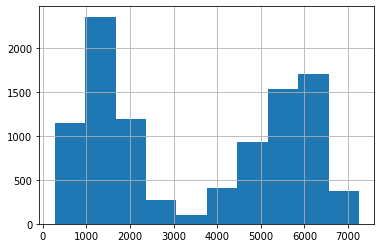

In [85]:
# Summary of Y variable

print(Y.describe())
Y.hist()

In [86]:
# transform zip to categorical

X['zip']= X['zip'].astype('str')

## Variable selection

### Continuous variables

In [87]:
cols_cont = X.select_dtypes([np.number]).drop(['Unnamed: 0', 'ID'], axis=1).columns.values.tolist() #only numeric
cols_cont = cols_cont[:-8] #remove items 
cols_cont

['Lat',
 'Lng',
 'Population',
 'Children',
 'Age',
 'Income',
 'outage_sec_perweek',
 'email',
 'contacts',
 'yearly_equip_failure',
 'Tenure',
 'MonthlyCharge']

In [88]:
# Cont cols (normalize for KNN)

# Continuous cols (normalize-for KNN)
X_cont = X[cols_cont]
X_cont.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge
0,37.37,-84.80,590,2,22,24892.19,7.98,10,0,1,6.80,89.98
1,41.78,-72.34,12396,4,72,6998.09,11.70,12,0,1,1.16,100.16
2,42.63,-84.54,21827,3,84,54665.60,10.75,9,0,1,15.75,99.95


### Categorical variables

In [89]:
# Cat cols-full list

cols_cat_all = X.loc[:, X.dtypes == np.object].columns.values.tolist() #have to translate back to list format
cols_cat_all = cols_cat_all[3:] #remove the first three cols, related to cust ID


In [90]:
# Cat cols-only those with limited tot unique value (otherwise too many categories created for dummies)

t = X[cols_cat_all].nunique().sort_values(ascending=False)
t = t.loc[lambda t: t < 20]  # change value to what is desired here, from 20
cols_cat_all_red = t.index.values.tolist()
X[cols_cat_all_red].nunique().to_frame('tot unique') #updated reduced list 


,tot unique
Education,12
Marital,5
Employment,5
PaymentMethod,4
InternetService,3
Gender,3
Area,3
Contract,3
Techie,2
PaperlessBilling,2


In [91]:
# 1. Create dummies-for categorical cols (use reduced col list)

X_cat = pd.get_dummies(X[cols_cat_all_red], drop_first=True) # drop first as it is redundant
print('number of cat cols chosen: ', X[cols_cat_all_red].shape[1])
print('total cat cols after one hot encoding: ', X_cat.shape[1])
X_cat.head(3)

number of cat cols chosen:  21
total cat cols after one hot encoding:  43


,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Contract_One year,Contract_Two Year,Techie_Yes,PaperlessBilling_Yes,Churn_Yes,Phone_Yes,Tablet_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,Port_modem_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Multiple_Yes
0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0
1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1,1
2,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,1,1


In [92]:
# Join Cat and Noncat together

X_all = pd.concat([X_cont, X_cat],axis=1)

print('total cols for final df: ', X_all.shape[1]) 
X_all.head()

total cols for final df:  55


,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Contract_One year,Contract_Two Year,Techie_Yes,PaperlessBilling_Yes,Churn_Yes,Phone_Yes,Tablet_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,Port_modem_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Multiple_Yes
0,37.37,-84.80,590,2,22,24892.19,7.98,10,0,1,6.80,89.98,1,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,1,0,1,0,0,0,1,0,0,1,0,1,1,1,1,0,1,0,0,1,0
1,41.78,-72.34,12396,4,72,6998.09,11.70,12,0,1,1.16,100.16,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,1,1,0,1,1,1,0,0,0,0,1,1,1
2,42.63,-84.54,21827,3,84,54665.60,10.75,9,0,1,15.75,99.95,0,0,0,0,0,0,1,0,0,0,0,1,0,0,0,0,0,1,0,1,0,0,0,0,0,0,0,0,0,1,1,1,1,1,0,0,0,0,1,0,0,1,1
3,41.17,-83.40,18690,7,73,16882.33,14.91,15,2,0,17.09,99.96,0,0,0,0,0,0,0,0,0,0,1,1,0,0,0,0,0,1,0,0,0,1,0,0,1,0,0,0,0,1,1,1,1,1,0,1,0,0,0,0,1,0,0
4,43.97,-69.23,1537,10,63,99740.63,8.15,16,2,1,1.67,87.47,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,1,0,1,0,0,0,0,0,0,0,0,0,0,0,0,0,1,1,1,0,0


# Train/Test Split Data

In [93]:
# Split the data into training and testing sets

from sklearn.model_selection import train_test_split

X_train, X_test, y_train, y_test = train_test_split(
    X_all, Y,
    test_size=0.3,
    random_state=1
)

In [94]:
# Print dimensions

print('Train cols: ', X_train.shape[1])
print('Test cols: ', X_test.shape[1])

Train cols:  55
Test cols:  55


# Predictive Modeling Techniques

# 1. KNN

This section covers KNN

In [95]:
# Load the K-Nearest Neighbors class
from sklearn.neighbors import KNeighborsRegressor

# Load the metrics libraries
from sklearn.metrics import mean_squared_error, r2_score

In [96]:
# Scale the data for cols_cont 

from sklearn.preprocessing import StandardScaler 

scaler = StandardScaler() #MinMaxScaler()

X_train_std = X_train.copy() #copy train features df for KNN
X_test_std = X_test.copy()  #copy test features df for KNN
X_train_std[cols_cont] = scaler.fit_transform(X_train_std[cols_cont]) 
X_test_std[cols_cont] = scaler.transform(X_test_std[cols_cont])

X_train_std.head(3)

,Lat,Lng,Population,Children,Age,Income,outage_sec_perweek,email,contacts,yearly_equip_failure,Tenure,MonthlyCharge,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,InternetService_Fiber Optic,InternetService_None,Gender_Male,Gender_Prefer not to answer,Area_Suburban,Area_Urban,Contract_One year,Contract_Two Year,Techie_Yes,PaperlessBilling_Yes,Churn_Yes,Phone_Yes,Tablet_Yes,OnlineSecurity_Yes,OnlineBackup_Yes,DeviceProtection_Yes,Port_modem_Yes,TechSupport_Yes,StreamingTV_Yes,StreamingMovies_Yes,Multiple_Yes
2228,-0.25,0.62,-0.62,-0.53,-0.07,0.64,-0.51,0.33,0.01,-0.63,-0.95,-0.66,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,0,1,0,1,0,0,0,1,0,0,1,1,0,1,0,0,1,1,0,0,1,0,0
5910,0.18,-0.04,-0.63,0.38,0.65,-0.82,0.81,1.32,0.01,-0.63,1.34,0.51,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,1,0,0,0,1,1,0,1,1,1,1,1,0,0,0,0,0
1950,0.83,1.34,0.10,-0.53,-0.83,1.26,1.21,1.99,0.01,-0.63,-1.24,0.52,0,1,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,1,0,0,1,1,0,0,0,0,0,1,0,0,1,1,0,1,0,1,0,1,1,1


In [97]:
# Train a K-Nearest Neighbors model

knn = KNeighborsRegressor(n_neighbors=6)
knn.fit(X_train_std, y_train)


KNeighborsRegressor(algorithm='auto', leaf_size=30, metric='minkowski',
                    metric_params=None, n_jobs=None, n_neighbors=6, p=2,
                    weights='uniform')

In [98]:
# Print overall test-set accuracy, precision, recall
y_pred = knn.predict(X_test_std)
error = np.sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
print('KNN RMSE value is:', error)
print('KNN R2:', r2_score(y_test, y_pred))

KNN RMSE value is: 648.4905483263219
KNN R2: 0.9126341965841064


# 2. Decision Tree

This section covers Decision Trees

In [99]:
from sklearn.tree import DecisionTreeRegressor

In [100]:
# Train a Random Forest

tree = DecisionTreeRegressor(max_depth=5)

tree.fit(X_train, y_train) 

DecisionTreeRegressor(ccp_alpha=0.0, criterion='mse', max_depth=5,
                      max_features=None, max_leaf_nodes=None,
                      min_impurity_decrease=0.0, min_impurity_split=None,
                      min_samples_leaf=1, min_samples_split=2,
                      min_weight_fraction_leaf=0.0, presort='deprecated',
                      random_state=None, splitter='best')

In [101]:
# Print overall test-set accuracy, precision, recall
y_pred = tree.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
print('DT RMSE value is:', error)
print('DT R2:', r2_score(y_test, y_pred))

DT RMSE value is: 180.32141321157224
DT R2: 0.9932449467267035


# 3. Random Forest 

This section covers Random Forest

In [102]:
from sklearn.ensemble import RandomForestRegressor

In [103]:
# Train a Random Forest

forest = RandomForestRegressor(
    n_estimators=100,
    max_features=15,
    max_depth=12,
    random_state=1,
)
forest.fit(X_train, y_train) 


RandomForestRegressor(bootstrap=True, ccp_alpha=0.0, criterion='mse',
                      max_depth=12, max_features=15, max_leaf_nodes=None,
                      max_samples=None, min_impurity_decrease=0.0,
                      min_impurity_split=None, min_samples_leaf=1,
                      min_samples_split=2, min_weight_fraction_leaf=0.0,
                      n_estimators=100, n_jobs=None, oob_score=False,
                      random_state=1, verbose=0, warm_start=False)

In [104]:
# Print overall test-set accuracy, precision, recall
y_pred = forest.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
print('RF RMSE value is:', error)
print('RF R2:', r2_score(y_test, y_pred))

RF RMSE value is: 214.03188785398763
RF R2: 0.9904831957155494


## Feature Importance for Random Forest

In [105]:
feature_imp = pd.Series(forest.feature_importances_,index=X_train.columns).sort_values(ascending=False)
feature_imp[:10]

Tenure               0.87
Churn_Yes            0.07
MonthlyCharge        0.01
Population           0.00
Lng                  0.00
Lat                  0.00
outage_sec_perweek   0.00
Income               0.00
Age                  0.00
email                0.00
dtype: float64

No handles with labels found to put in legend.


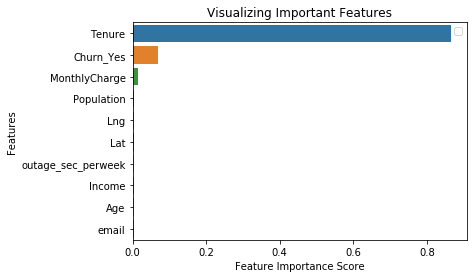

In [106]:
import matplotlib.pyplot as plt
import seaborn as sns
%matplotlib inline
# Creating a bar plot
sns.barplot(x=feature_imp[:10], y=feature_imp[:10].index)
# Add labels to your graph
plt.xlabel('Feature Importance Score')
plt.ylabel('Features')
plt.title("Visualizing Important Features")
plt.legend()
plt.show()

# 4. Advanced Regression

This section covers Ridge and Lasso Regression

In [79]:
from sklearn.linear_model import Ridge, Lasso, LassoCV

## Ridge

In [80]:
# Train Ridge model

ridge = Ridge(alpha=.01)
ridge.fit(X_train, y_train)

Ridge(alpha=0.01, copy_X=True, fit_intercept=True, max_iter=None,
      normalize=False, random_state=None, solver='auto', tol=0.001)

In [81]:
# Print overall test-set accuracy, precision, recall
y_pred = ridge.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
print('Ridge RMSE value is:', error)
print('Ridge R2:', r2_score(y_test, y_pred))

Ridge RMSE value is: 0.4253896421100764
Ridge R2: 0.9975461339404736


## Lasso

In [82]:
# Train Lasso model

lasso = Lasso(alpha=485.824775)
lasso.fit(X_train, y_train)

Lasso(alpha=485.824775, copy_X=True, fit_intercept=True, max_iter=1000,
      normalize=False, positive=False, precompute=False, random_state=None,
      selection='cyclic', tol=0.0001, warm_start=False)

In [83]:
# Print overall test-set accuracy, precision, recall
y_pred = lasso.predict(X_test)
error = np.sqrt(mean_squared_error(y_test,y_pred)) #calculate rmse
print('Lasso RMSE value is:', error)
print('Lasso R2:', r2_score(y_test, y_pred))

Lasso RMSE value is: 8.514296534667116
Lasso R2: 0.016952336992303696


### Lasso with CV (extra)

In [39]:
lasso = LassoCV()
lasso.fit(X_train1, y_train_log1)

LassoCV(alphas=None, copy_X=True, cv=None, eps=0.001, fit_intercept=True,
        max_iter=1000, n_alphas=100, n_jobs=None, normalize=False,
        positive=False, precompute='auto', random_state=None,
        selection='cyclic', tol=0.0001, verbose=False)

In [40]:
print("Best alpha using built-in LassoCV: %f" % lasso.alpha_)
print("Best score using built-in LassoCV: %f" %lasso.score(X_train1, y_train_log1))
coef = pd.Series(lasso.coef_, index = X_train1.columns)

Best alpha using built-in LassoCV: 0.392031
Best score using built-in LassoCV: 0.877798


In [41]:
print("Lasso picked " + str(sum(coef != 0)) + " variables and eliminated the other " +  str(sum(coef == 0)) + " variables")

Lasso picked 4 variables and eliminated the other 55 variables


Text(0.5, 1.0, 'Feature importance using Lasso Model')

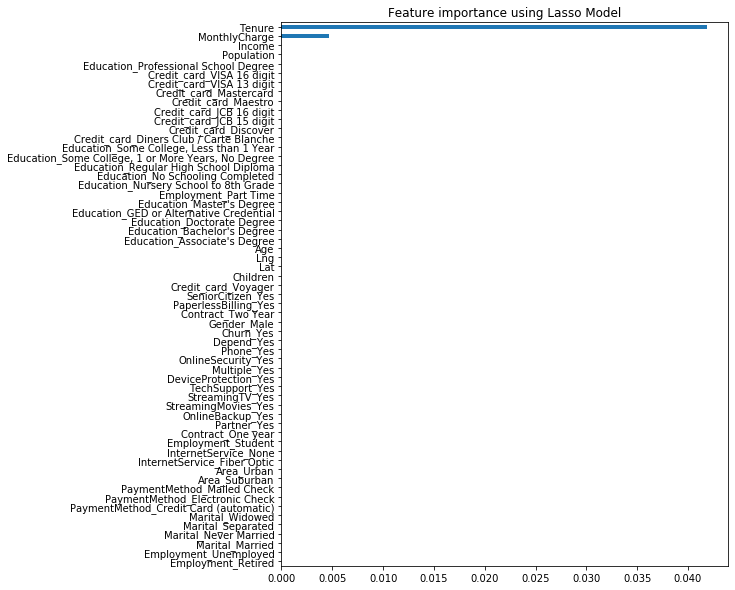

In [48]:
imp_coef = coef.sort_values()
import matplotlib
matplotlib.rcParams['figure.figsize'] = (8.0, 10.0)
imp_coef.plot(kind = "barh")
plt.title("Feature importance using Lasso Model")

## Linear reg

In [49]:
# Train linear reg model 

from sklearn.linear_model import LinearRegression
linear = LinearRegression()
linear.fit(X_train1, y_train_log1)

LinearRegression(copy_X=True, fit_intercept=True, n_jobs=None, normalize=False)

In [50]:
# Print overall test-set accuracy, precision, recall
y_pred = linear.predict(X_test)
error = np.sqrt(mean_squared_error(y_test_log,y_pred)) #calculate rmse
print('LR RMSE value is:', error)
print('LR R2:', r2_score(y_test_log, y_pred)) 

LR RMSE value is: 0.4358747527862019
LR R2: 0.8726931554535339


In [51]:
t1 = []
t2 = []
for (columnName, columnData) in X_train1.iteritems():
    t1.append(columnName)
    t2.append(columnData.corr(y_train_log1))
    
df = pd.DataFrame({'X_train col': t1, 'Correlation': t2})

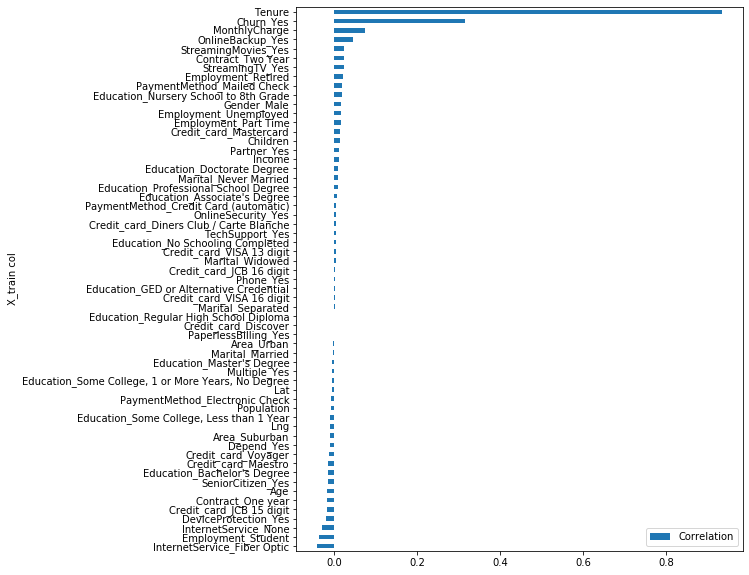

In [52]:
df.sort_values('Correlation',ascending=False)
df.sort_values('Correlation').plot.barh(x='X_train col', y='Correlation')

In [90]:
X_train.sample(3)

,Population,Children,Lat,Lng,Income,Age,Tenure,MonthlyCharge,Education_Associate's Degree,Education_Bachelor's Degree,Education_Doctorate Degree,Education_GED or Alternative Credential,Education_Master's Degree,Education_No Schooling Completed,Education_Nursery School to 8th Grade,Education_Professional School Degree,Education_Regular High School Diploma,"Education_Some College, 1 or More Years, No Degree","Education_Some College, Less than 1 Year",Credit_card_Diners Club / Carte Blanche,Credit_card_Discover,Credit_card_JCB 15 digit,Credit_card_JCB 16 digit,Credit_card_Maestro,Credit_card_Mastercard,Credit_card_VISA 13 digit,Credit_card_VISA 16 digit,Credit_card_Voyager,Employment_Part Time,Employment_Retired,Employment_Student,Employment_Unemployed,Marital_Married,Marital_Never Married,Marital_Separated,Marital_Widowed,PaymentMethod_Credit Card (automatic),PaymentMethod_Electronic Check,PaymentMethod_Mailed Check,Area_Suburban,Area_Urban,InternetService_Fiber Optic,InternetService_None,Contract_One year,Contract_Two Year,Partner_Yes,OnlineBackup_Yes,StreamingMovies_Yes,StreamingTV_Yes,TechSupport_Yes,DeviceProtection_Yes,Multiple_Yes,OnlineSecurity_Yes,Phone_Yes,Depend_Yes,Churn_Yes,Gender_Male,PaperlessBilling_Yes,SeniorCitizen_Yes
2366,41665,0,33.81592,-84.55204,23913.39,60,1.582585,104.969934,0,1,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,0,0,0,0,0,1,1,0,1,1,0,0,1,0,1,1,1,0
683,1535,1,33.54826,-90.52479,7056.15,58,7.847288,82.484375,0,0,0,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,0,0,1,0,0,1,0,0,0,0,0,1,0,1,0,0,1,0,0
3162,12824,3,39.90362,-75.29342,29721.03,55,1.481645,87.480560,0,0,0,0,0,0,0,0,0,0,0,0,0,1,0,0,0,0,0,0,1,0,0,0,1,0,0,0,0,0,1,1,0,0,1,0,1,0,0,0,1,0,0,0,1,1,0,1,0,1,0


In [24]:
y_train_log = np.log(y_train) 
y_test_log = np.log(y_test) 

In [25]:
y_train

2228    831.64
5910   7022.88
1950    227.73
2119   1336.93
5947   4214.75
         ...  
2895   1221.65
7813   6485.16
905     962.46
5192   5593.44
235    2071.87
Name: TotalCharge, Length: 7000, dtype: float64

In [26]:
y_train_log

2228   6.72
5910   8.86
1950   5.43
2119   7.20
5947   8.35
       ... 
2895   7.11
7813   8.78
905    6.87
5192   8.63
235    7.64
Name: TotalCharge, Length: 7000, dtype: float64

In [27]:
y_train_log[y_train_log.isnull()]

4874   nan
Name: TotalCharge, dtype: float64

In [28]:
y_train_log.shape

(7000,)

In [29]:
y_train_log1 = y_train_log.drop(4874)
X_train1 = X_train.drop(4874)

In [30]:
y_train_log1.shape

(6999,)

In [31]:
X_train1.shape

(6999, 59)